# DD2424 Assignment 3

**Authors:** Navid Farhadi (nfarhadi@kth.se)

**Course Instance:** DD2424 Deep Learning in Data Science VT19

### Exercise I: Computing the Gradient

The gradient of $W$ and $b$ is computed using the `computeGradients()` function. I was able to successfully write this function and the other necessary functions needed in order to compute the gradients of $W$ and $b$. In order to verify that the functions were written correctly I wrote the `computeGradientsNumerically()` function that computes the gradients using the finite difference method as well as the `compareGradients()` method that finds the relative error between the numerically computer gradient and analytically computed gradient.

Unfortunately `computeGradientsNumerically()` takes a very long time to run when using the entire data set so I tested the function using only subsets of the data with reduced dimensionality:

### Exercise II: 3-Layer Network

#### Without Batch Normalization

Final test accuracy: 53.04 %


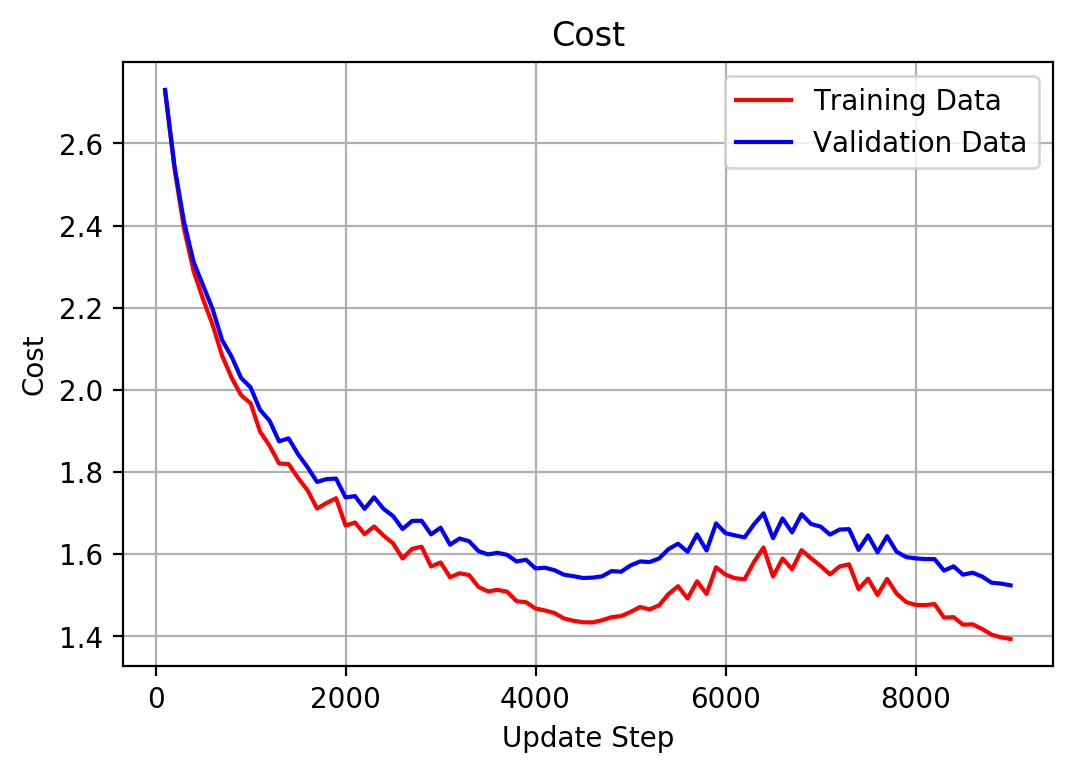

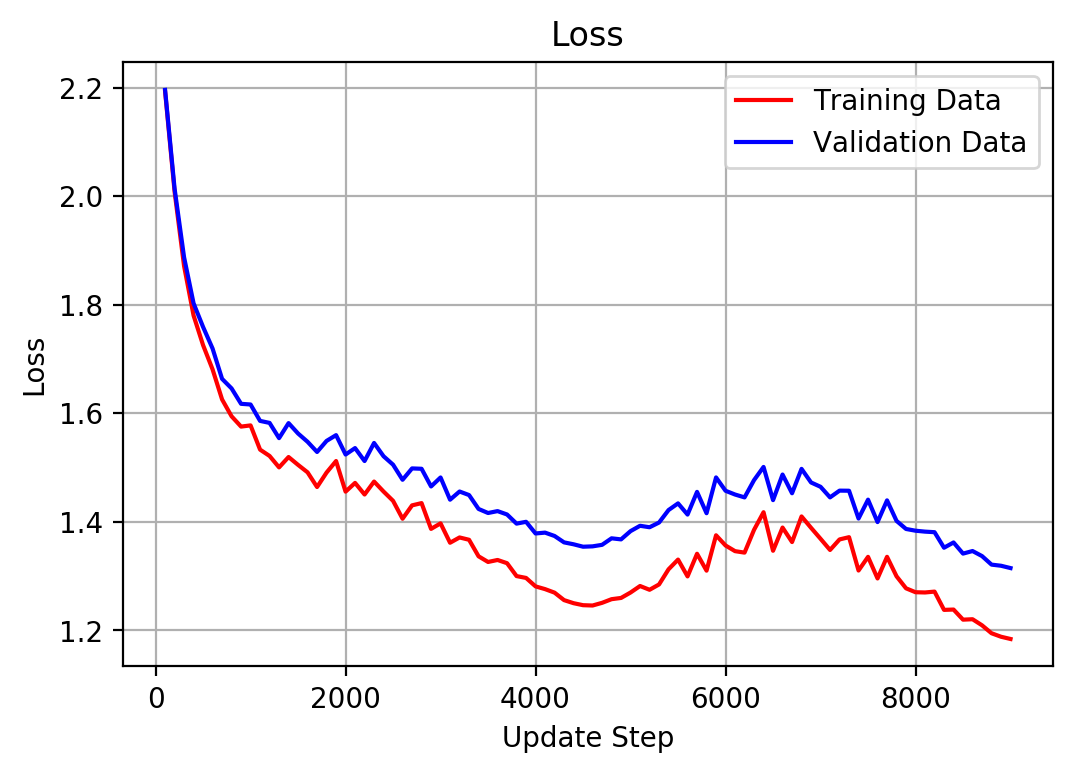

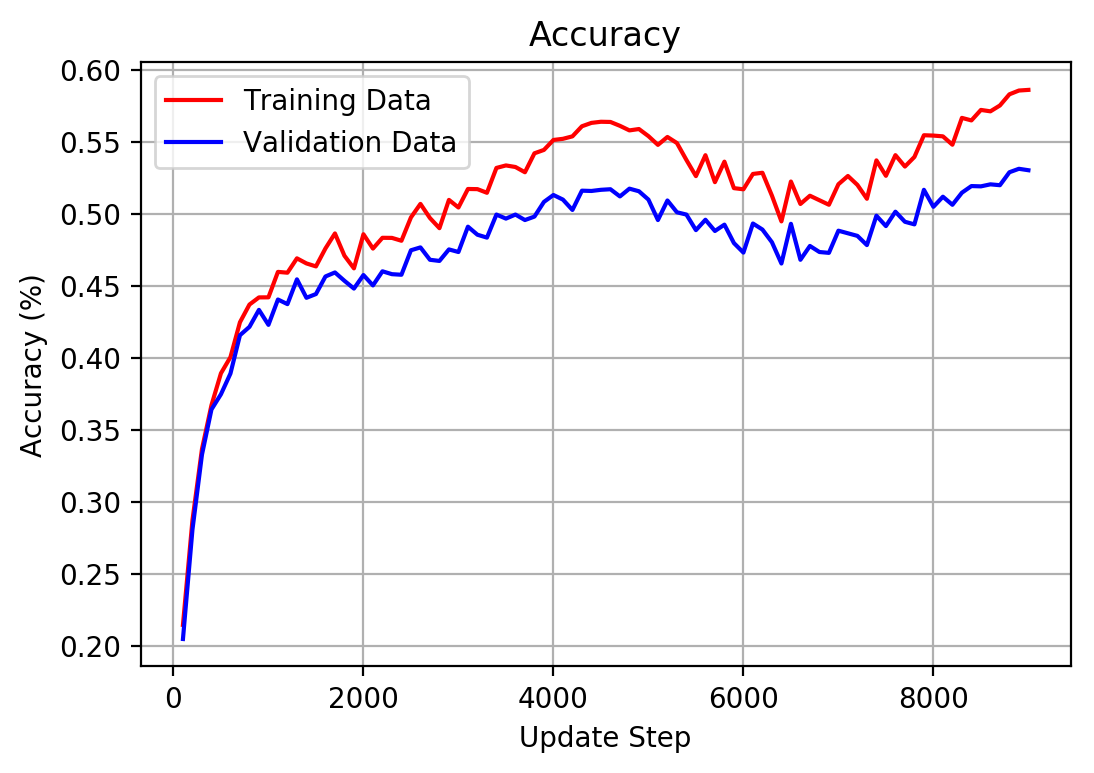

In [18]:
run([50,50],0.005,2,"big",False)

#### With Batch Normalization

In [ ]:
run([50,50],0.005,2,"big",True)

### Exercise III: 9-Layer Network

#### Without Batch Normalization

Final test accuracy: 40.22 %


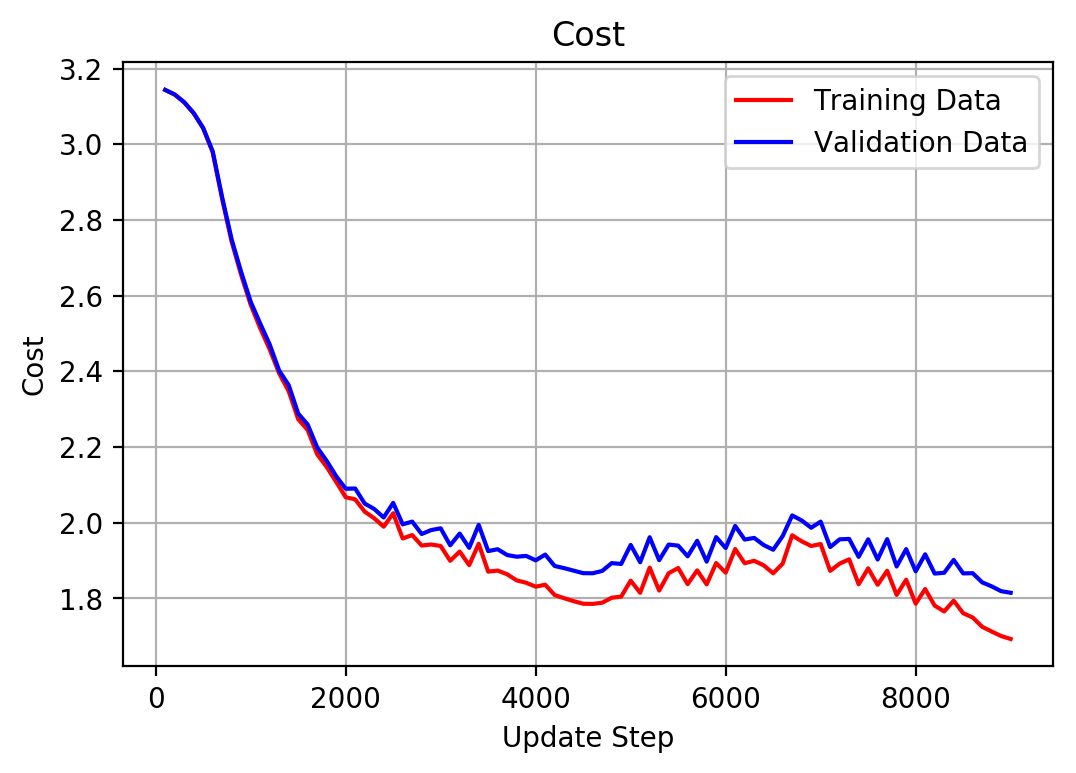

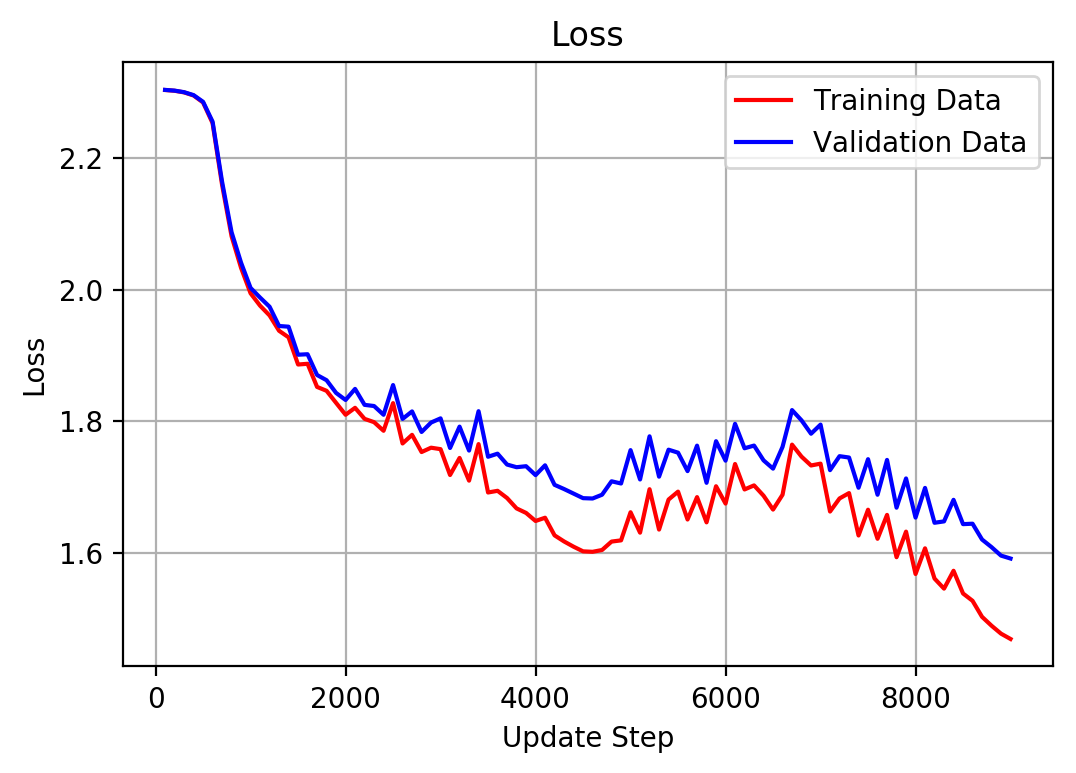

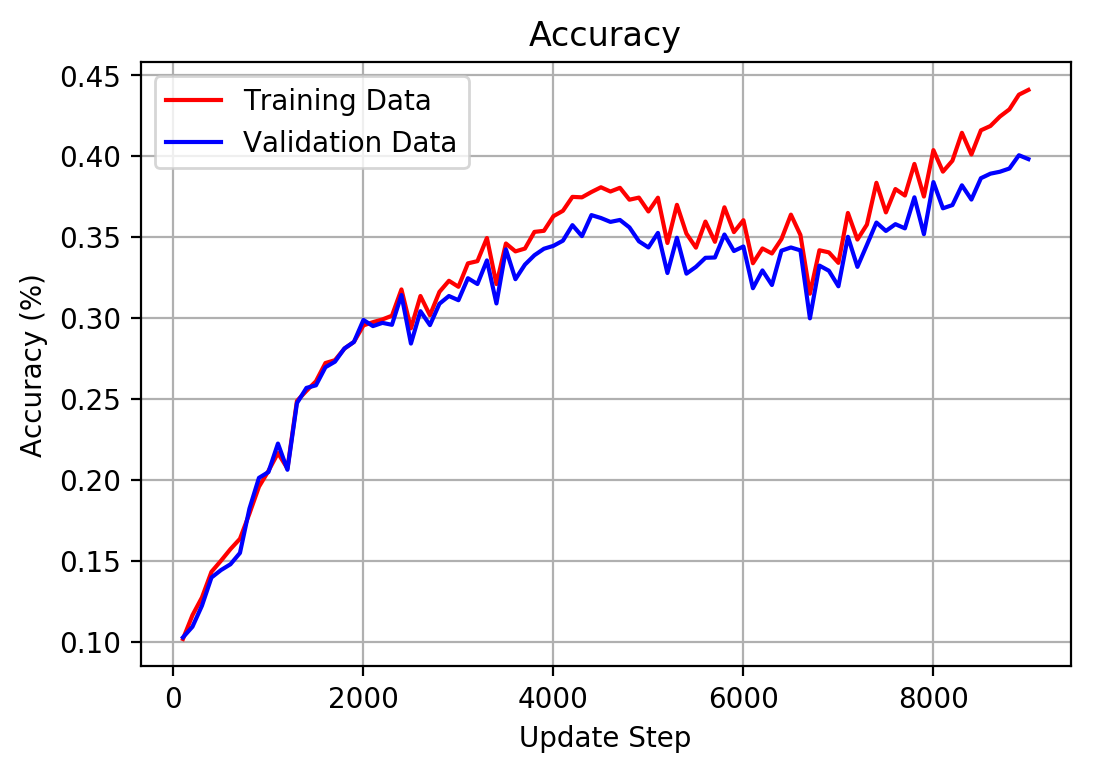

In [15]:
run([50,30,20,20,10,10,10,10],0.005,2,"big",False)

#### With Batch Normalization

Final test accuracy: 50.41 %


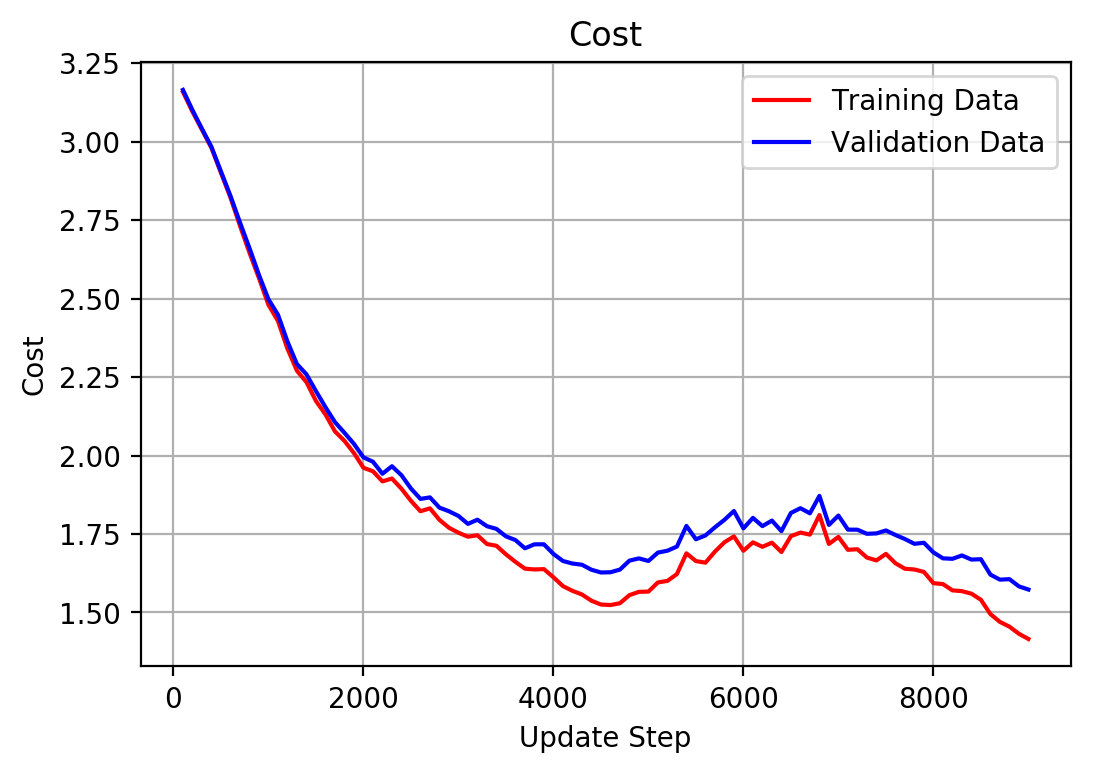

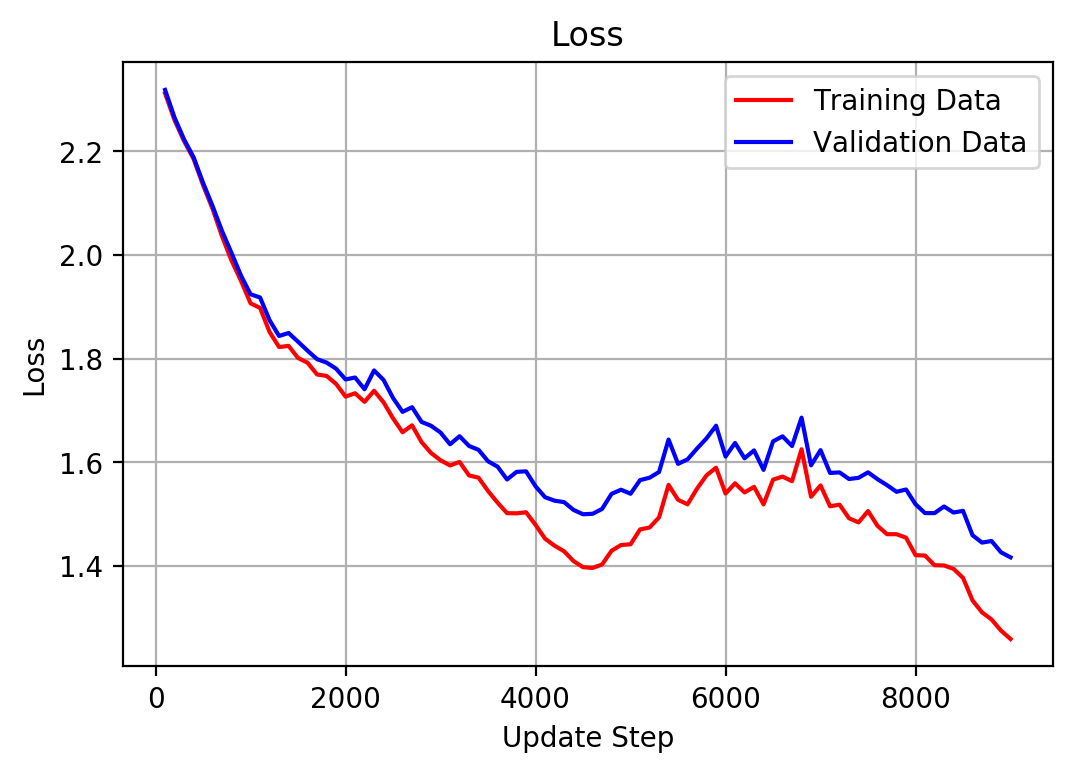

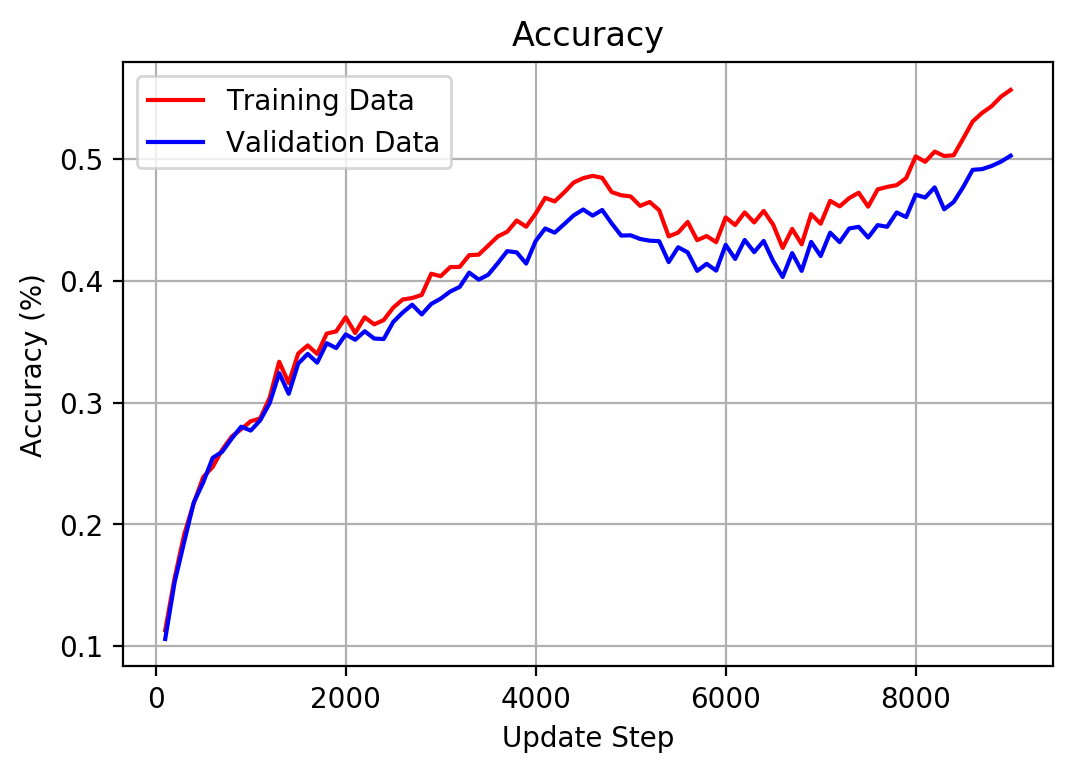

In [16]:
run([50,30,20,20,10,10,10,10],0.005,2,"big",True)

### Exercise IV: Searching for Optimal Lambda

### Exercise V: Sensitivity to Initialization

### Implementation

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import pickle
import math

N = 10000
d = 3072
k = 10
m = 50
eps = np.finfo(float).eps
eta_min = 1e-5
eta_max = 1e-1
n_batch = 100

def loadBatch(filename):
    with open("./cifar-10-batches-py/" + filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    X = np.array(dict[b'data']/255).T
    X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

    y = np.array(dict[b'labels'])
    
    Y = np.zeros((k,N))
    for i in range(N):
        Y[y[i]][i] = 1
    
    fo.close()
    return X,Y,y

def initialize(hidden_nodes, batch_norm):
    hidden_nodes.append(k)
    
    Ws = []
    bs = []

    Ws.append(np.random.normal(0.0,1/np.sqrt(d),(hidden_nodes[0],d)))
    bs.append(np.zeros((hidden_nodes[0],1)))

    if batch_norm:
        gammas = []
        gammas.append(np.random.normal(0.0,1/np.sqrt(d),(hidden_nodes[0],1)))
        betas = []
        betas.append(np.random.normal(0.0,1/np.sqrt(d),(hidden_nodes[0],1)))

    for layer in range(1,len(hidden_nodes)):
        Ws.append(np.random.normal(0.0,np.sqrt(1/Ws[layer-1].shape[0]),(hidden_nodes[layer],Ws[layer-1].shape[0])))
        bs.append(np.zeros((hidden_nodes[layer],1)))
        if batch_norm and layer < len(hidden_nodes) - 1:
            gammas.append(np.random.normal(0.0,np.sqrt(1/Ws[layer-1].shape[0]),(hidden_nodes[layer],1)))
            betas.append(np.random.normal(0.0,np.sqrt(1/Ws[layer-1].shape[0]),(hidden_nodes[layer],1)))

    if batch_norm:
        return Ws, bs, gammas, betas
    
    return Ws, bs, None, None

def shuffle_data(X,Y):
    index = np.arange(X.shape[1])
    np.random.shuffle(index)
    X = X[:, index]
    Y = Y[:, index]
    return X, Y

def BatchNormalize(s, mean = None, variance = None):
    if mean is None:
        mean = np.mean(s, axis=1, keepdims=True)
    if variance is None:
        variance = np.var(s, axis=1, keepdims=False)

    s_hat = np.dot(np.diag(1/np.sqrt(variance+eps)), s-mean)
    return s_hat, mean, variance

def BatchNormalizeBackPass(g, S, mean):
    sigma1 = 1/np.sqrt(np.mean(np.power((S-mean),2),axis=1,keepdims=True))
    sigma2 = np.power(sigma1,3)
    G1 = np.multiply(g,sigma1)
    G2 = np.multiply(g,sigma2)
    D = np.subtract(S,mean)
    c = np.sum(np.multiply(G2,D),axis = 1,keepdims = True)

    return np.subtract(np.subtract(G1,np.sum(G1,axis = 1,keepdims = True)/S.shape[1]),np.multiply(D,c)/S.shape[1])

def evaluateClassifier(X, Ws, bs, gammas, betas, batch_norm):
    hs = [X]
    Ss = []
    S_hats = []
    means = []
    variances = []

    n_layers = len(Ws)

    for layer in range(n_layers - 1):
        Ss.append(np.dot(Ws[layer],hs[layer]) + bs[layer])
        if batch_norm:
            s_hat, mean, variance = BatchNormalize(Ss[layer])
            S_hats.append(s_hat)
            means.append(mean)
            variances.append(variance)
            s = np.multiply(gammas[layer], s_hat) + bs[layer]
            hs.append(np.maximum(0,s))
        else:
            hs.append(np.maximum(0,Ss[layer]))
    
    s = np.dot(Ws[n_layers-1],hs[n_layers-1]) + bs[n_layers-1]
    p = np.exp(s) / np.sum(np.exp(s),axis=0)

    return p, hs, Ss, S_hats, means, variances

def computeCost(P, Y, Ws, l):
    p_y = np.multiply(Y,P).sum(axis=0)
    p_y[p_y == 0] = eps

    sum = 0
    for i in range(len(Ws)):
        sum += np.sum(np.square(Ws[i]))
    
    regularization = l * sum

    loss = -np.log(p_y).sum() / P.shape[1]
    cost = loss + regularization
    return loss, cost

def computeAccuracy(P, y):
    predictions = np.argmax(P, axis=0)
    return np.sum(predictions == y) / P.shape[1]

def computeGradients(X, Y, Ws, bs, gammas, betas, l, batch_norm):
    grad_Ws = []
    grad_bs = []
    grad_gammas = []
    grad_betas = []

    layer = len(Ws) - 1

    p, hs, Ss, S_hats, means, variances = evaluateClassifier(X,Ws,bs,gammas,betas,batch_norm)
    g = -(Y-p)
    grad_bs.append(np.dot(g,np.ones((X.shape[1],1))) / X.shape[1])
    grad_Ws.append(np.add(np.dot(g,hs[layer].T) / X.shape[1], 2*l*Ws[layer]))

    g = np.multiply(np.dot(Ws[layer].T,g),1*(hs[layer]>0))
    layer -= 1

    while(layer >= 0):
        if batch_norm:
            grad_gammas.append(np.dot(np.multiply(g,S_hats[layer]),np.ones((X.shape[1],1)))/X.shape[1]) 
            grad_betas.append(np.dot(g,np.ones((X.shape[1],1)))/X.shape[1])
            g = BatchNormalizeBackPass(np.multiply(g, np.dot(gammas[layer],np.ones((X.shape[1],1)).T)), Ss[layer],means[layer])
        
        grad_bs.append(np.dot(g,np.ones((X.shape[1],1))) / X.shape[1])
        grad_Ws.append(np.add(np.dot(g,hs[layer].T) / X.shape[1], 2*l*Ws[layer]))

        if(layer != 0):
            g = np.multiply(np.dot(Ws[layer].T,g),1*(hs[layer]>0))
        
        layer -= 1

    grad_Ws.reverse()
    grad_bs.reverse()
    
    if batch_norm:
        grad_gammas.reverse()
        grad_betas.reverse()
        return grad_Ws, grad_bs, grad_gammas, grad_betas
    else:
        return grad_Ws, grad_bs, None, None


def computeGradientsNumerically(X,Y,Ws,bs,gammas,betas,l, batch_norm):
    grad_Ws = []
    grad_bs = []
    grad_gammas = []
    grad_betas = []

    n_layers = len(Ws)
    h = 1e-5

    for layer in range(n_layers):
        grad_W = np.zeros_like(Ws[layer])
        grad_b = np.zeros_like(bs[layer])
        if batch_norm and layer < n_layers - 1:
            grad_gamma = np.zeros_like(gammas[layer])
            grad_beta = np.zeros_like(betas[layer])

        for i in range(bs[layer].shape[0]):
            copy = np.copy(bs[layer])
            temp = copy
            temp[i] += h
            bs[layer] = temp
            p, hs, Ss, S_hats, means, variances = evaluateClassifier(X,Ws,bs,gammas,betas,batch_norm)
            loss, c1 = computeCost(p,Y,Ws,l)
            temp = copy
            temp[i] -= h
            bs[layer] = temp
            p, hs, Ss, S_hats, means, variances = evaluateClassifier(X,Ws,bs,gammas,betas,batch_norm)
            loss, c2 = computeCost(p,Y,Ws,l)
            bs[layer] = copy
            grad_b[i] = (c1-c2)/h
        
        for i in range(Ws[layer].shape[0]):
            for j in range(Ws[layer].shape[1]):
                copy = np.copy(Ws[layer])
                temp = copy
                temp[i][j] += h
                Ws[layer] = temp
                p, hs, Ss, S_hats, means, variances = evaluateClassifier(X,Ws,bs,gammas,betas,batch_norm)
                loss, c1 = computeCost(p,Y,Ws,l)
                temp = copy
                temp[i][j] -= h
                Ws[layer] = temp
                p, hs, Ss, S_hats, means, variances = evaluateClassifier(X,Ws,bs,gammas,betas,batch_norm)
                loss, c2 = computeCost(p,Y,Ws,l)
                Ws[layer] = copy
                grad_W[i][j] = (c1-c2)/h
        
        grad_bs.append(grad_b)
        grad_Ws.append(grad_W)

        if batch_norm and layer < n_layers - 1:
            for i in range(gammas[layer].shape[0]):
                copy = np.copy(gammas[layer])
                temp = copy
                temp[i] += h
                gammas[layer] = temp
                p, hs, Ss, S_hats, means, variances = evaluateClassifier(X,Ws,bs,gammas,betas,batch_norm)
                loss, c1 = computeCost(p,Y,Ws,l)
                temp = copy
                temp[i] -= h
                gammas[layer] = temp
                p, hs, Ss, S_hats, means, variances = evaluateClassifier(X,Ws,bs,gammas,betas,batch_norm)
                loss, c2 = computeCost(p,Y,Ws,l)
                gammas[layer] = copy
                grad_gamma[i] = (c1-c2)/h
            
            for i in range(betas[layer].shape[0]):
                copy = np.copy(betas[layer])
                temp = copy
                temp[i] += h
                betas[layer] = temp
                p, hs, Ss, S_hats, means, variances = evaluateClassifier(X,Ws,bs,gammas,betas,batch_norm)
                loss, c1 = computeCost(p,Y,Ws,l)
                temp = copy
                temp[i] -= h
                betas[layer] = temp
                p, hs, Ss, S_hats, means, variances = evaluateClassifier(X,Ws,bs,gammas,betas,batch_norm)
                loss, c2 = computeCost(p,Y,Ws,l)
                betas[layer] = copy
                grad_beta[i] = (c1-c2)/h
            
            grad_gammas.append(grad_gamma)
            grad_betas.append(grad_beta)

    if batch_norm:
        return grad_Ws, grad_bs, grad_gammas, grad_betas
    else:
        return grad_Ws, grad_bs, None, None

def compareGradients(X,Y,Ws,bs,gammas,betas,l,batch_norm):
    grad_Ws,grad_bs,grad_gammas,grad_betas = computeGradients(X,Y,Ws,bs,gammas,betas,l,batch_norm)
    grad_Ws_num,grad_bs_num,grad_gammas_num,grad_betas_num = computeGradientsNumerically(X,Y,Ws,bs,gammas,betas,l,batch_norm)

    for layer in range(len(Ws)):
        print("Relative error for Layer " + str(layer+1) + " W: " + str(np.abs(grad_Ws[layer] - grad_Ws_num[layer]).sum()))
        print("Relative error for Layer " + str(layer+1) + " b: " + str(np.abs(grad_bs[layer] - grad_bs_num[layer]).sum()))
        if batch_norm and layer < len(Ws) - 1:
            print("Relative error for Layer " + str(layer+1) + " gamma: " + str(np.abs(grad_gammas[layer] - grad_gammas_num[layer]).sum()))
            print("Relative error for Layer " + str(layer+1) + " beta: " + str(np.abs(grad_betas[layer] - grad_betas_num[layer]).sum()))

def cycleETA(t, l_cycles, n_s, eta):
    eta_lower = 2*l_cycles*n_s
    eta_mid = (2*l_cycles + 1) * n_s
    eta_upper = 2*(l_cycles + 1) * n_s
    eta_range = eta_max - eta_min

    if (eta_lower <= t) and (t <= eta_mid):
        eta = eta_min + eta_range*(t-eta_lower)/n_s
    elif (eta_mid <= t) and (t <= eta_upper):
        eta = eta_max - eta_range*(t-eta_mid)/n_s
    
    return eta

def getData(data_set):
    X,Y,y = loadBatch("data_batch_1")

    if data_set == "big":
        for i in range(2,6):
            X_temp, Y_temp, y_temp = loadBatch("data_batch_" + str(i))
            X = np.append(X,X_temp,axis=1)
            Y = np.append(Y,Y_temp,axis=1)
            y = np.append(y,y_temp,axis=0)
        X,X_val = np.split(X,[45000],axis=1)
        Y,Y_val = np.split(Y,[45000],axis=1)
        y,y_val = np.split(y,[45000],axis=0)
    elif data_set == "bigger":
        for i in range(2,6):
            X_temp, Y_temp, y_temp = loadBatch("data_batch_" + str(i))
            X = np.append(X,X_temp,axis=1)
            Y = np.append(Y,Y_temp,axis=1)
            y = np.append(y,y_temp,axis=0)
        X,X_val = np.split(X,[49000],axis=1)
        Y,Y_val = np.split(Y,[49000],axis=1)
        y,y_val = np.split(y,[49000],axis=0)
    else:
        X_val, Y_val, y_val = loadBatch("data_batch_2")
    
    X_test, Y_test, y_test = loadBatch("test_batch")

    return X, Y, y, X_val, Y_val, y_val, X_test, Y_test, y_test
    
def miniBatch(Ws, bs, gammas, betas, l, eta, n_s, n_cycles, data_set, batch_norm):
    X, Y, y, X_val, Y_val, y_val, X_test, Y_test, y_test = getData(data_set)

    train_acc = []
    train_loss = []
    train_cost = []
    val_acc = []
    val_loss = []
    val_cost = []
    iterations = []

    t = 0
    l_cycles = -1
    n_layers = len(Ws)

    n_epochs = math.ceil(2*n_cycles*n_s/(X.shape[1]/n_batch))

    for i in range(n_epochs):
        shuffle_data(X,Y)
        for j in range(0, X.shape[1], n_batch):
            grad_Ws, grad_bs, grad_gammas, grad_betas = computeGradients(X[:,j:j+n_batch],Y[:,j:j+n_batch],Ws,bs,gammas,betas,l,batch_norm)

            for layer in range(n_layers):
                Ws[layer] -= eta*grad_Ws[layer]
                bs[layer] -= eta*grad_bs[layer]
                if batch_norm:
                    if layer == n_layers - 1:
                        break
                    else:
                        gammas[layer] -= eta*grad_gammas[layer]
                        betas[layer] -= eta*grad_betas[layer]

            if t % (2 * n_s) == 0:
                l_cycles += 1
            
            eta = cycleETA(t,l_cycles,n_s, eta)
            t += 1

            if(t % 100 == 0):
                iterations.append(t)
                P,_,_,_,_,_ = evaluateClassifier(X, Ws, bs, gammas, betas, batch_norm)
                P_val,_,_,_,_,_ = evaluateClassifier(X_val, Ws, bs, gammas, betas, batch_norm)
        
                train_acc.append(computeAccuracy(P,y))
                val_acc.append(computeAccuracy(P_val,y_val))

                temp_loss, temp_cost = computeCost(P, Y, Ws, l)
                train_loss.append(temp_loss)
                train_cost.append(temp_cost)

                temp_loss, temp_cost = computeCost(P_val, Y_val, Ws, l)
                val_loss.append(temp_loss)
                val_cost.append(temp_cost)

    P_test,_,_,_,_,_ = evaluateClassifier(X_test,Ws,bs,gammas,betas,batch_norm)
    test_acc = computeAccuracy(P_test,y_test)
    test_loss = computeCost(P_test,Y_test,Ws,l)

    return train_acc, train_loss, train_cost, val_acc, val_loss, val_cost, test_acc, test_loss, iterations

def run(hidden_nodes, l, n_cycles, data_set,batch_norm):
    Ws, bs, gammas, betas = initialize(hidden_nodes,batch_norm)
    n_s = 5*45000/n_batch
    eta = 0.00001
    train_acc, train_loss, train_cost, val_acc, val_loss, val_cost, test_acc, test_loss, iterations = miniBatch(Ws, bs, gammas, betas, l, eta, n_s, n_cycles, data_set, batch_norm)

    print("Final test accuracy: " + str(test_acc*100) + " %")
    
    plt.rcParams['figure.dpi'] = 100
    
    plt.figure(1)
    plt.plot(iterations, train_cost, "r-", label="Training Data")
    plt.plot(iterations, val_cost, "b-", label="Validation Data")
    plt.title("Cost")
    plt.xlabel("Update Step")
    plt.ylabel("Cost")
    plt.legend()
    plt.grid("true")
    plt.show()

    plt.figure(2)
    plt.plot(iterations, train_loss, "r-", label="Training Data")
    plt.plot(iterations, val_loss, "b-", label="Validation Data")
    plt.title("Loss")
    plt.xlabel("Update Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid("true")
    plt.show()

    plt.figure(3)
    plt.plot(iterations, train_acc, "r-", label="Training Data")
    plt.plot(iterations, val_acc, "b-", label="Validation Data")
    plt.title("Accuracy")
    plt.xlabel("Update Step")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid("true")
    plt.show()

def findLambdas(hidden_nodes,n_lambda,lambda_min,lambda_max,eta,n_cycles,batch_norm):
    lambda_range = lambda_max - lambda_min
    n_s = 2 * math.floor(45000 / n_batch)
    
    lambdas = []
    testAcc = []
    trainAcc = []
    valAcc = []

    for i in range(n_lambda):
        Ws, bs, gammas, betas = initialize(hidden_nodes,batch_norm)
        _lambda = math.pow(10,lambda_min + lambda_range * np.random.rand())
        train_acc, train_loss, train_cost, val_acc, val_loss, val_cost, test_acc, test_loss, iterations = miniBatch(Ws,bs,gammas,betas,_lambda,eta,n_s,n_cycles,"big",batch_norm)
        lambdas.append(_lambda)
        testAcc.append(test_acc)
        trainAcc.append(max(train_acc))
        valAcc.append(max(val_acc))
    
    results = sorted(zip(valAcc,testAcc,trainAcc,lambdas), reverse=True)[:3]
    print()
    print("Three Best Performing Networks (by validation accuracy) ")
    print("eta = " + str(eta) + ", n_cycles = " + str(n_cycles) + ", n_s = " + str(n_s))
    print("---")

    for valacc,testacc,trainacc,_l in results:
        print("Lambda: " + str(_l))
        print("Test Accuracy: " + str(testacc))
        print("Best Validation Accuracy: " + str(valacc))
        print("Best Training Accuracy: " + str(trainacc))
        print()